<a href="https://colab.research.google.com/github/Doris-QZ/spooky_author_identification/blob/main/1_LSTM_Spooky_Author_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This project is based on the expired Kaggle competition, Spooky Author Identification. In this project, I will train machine learning models to identify the author of excerpts from horror stories written by Edgar Allan Poe (EAP), H.P. Lovecraft (HPL), and Mary Shelley (MWS). This author identification task involves predicting the author based on their writing style.


The primary challenge of this task lies in the excerpts originating from the same genre (horror story). In same-genre texts, the thematic content and vocabulary often overlap across authors, making it difficult to distinguish them. In my final project for the ‘Unsupervised Algorithms in Machine Learning’ course, I explored a hybrid approach, combining unsupervised and supervised techniques, and achieved a test accuracy of 0.78. This outperformed the purely supervised base model, which had an accuracy of 0.69. In the conclusion of the final report, I proposed that future research could explore the application of deep learning models, such as Recurrent Neural Networks (RNNs), which may better capture the nuances of same-genre texts, potentially improving test accuracy and providing new insights into authorship attribution.

Therefore, in this project, I will explore three deep learning models: LSTM (Long Short-Term Memory, a type of RNN), LSTM with GloVe Embedding, and a fine-tuned BERT model—to see how they perform on author identification within the same genre.

### Data
The dataset contains text from works of fiction written by three authors: Edgar Allan Poe, HP Lovecraft and Mary Shelley. There are 19,579 entries with three attributes--id, text, and author--in the training set. The 'text' column contains excerpts from horror stories, and the 'author' column indicates who wrote each excerpt.

**Data Source** Meg Risdal and Rachael Tatman. Spooky Author Identification. https://kaggle.com/competitions/spooky-author-identification, 2017. Kaggle.

**Connect to Kaggle and download the dataset**

In [ ]:
# Install Kaggle library
!pip install kaggle

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Make a directory for kaggle
!mkdir ~/.kaggle

# Copy the kaggle.json file to the directory
!cp /content/drive/MyDrive/ColabNotebooks/Kaggle_API_Key/kaggle.json ~/.kaggle/

# Change the file permissions to read/write to the owner only
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle competitions download spooky-author-identification

# Unzip the data
!unzip spooky-author-identification.zip
!unzip train.zip
!unzip test.zip
!unzip sample_submission.zip

Mounted at /content/drive
100% 1.81M/1.81M [00:01<00:00, 1.95MB/s]
100% 1.81M/1.81M [00:01<00:00, 1.73MB/s]
Archive:  spooky-author-identification.zip
  inflating: sample_submission.zip   
  inflating: test.zip                
  inflating: train.zip               
Archive:  train.zip
  inflating: train.csv               
Archive:  test.zip
  inflating: test.csv                
Archive:  sample_submission.zip
  inflating: sample_submission.csv   


In [2]:
!pip install textstat
!pip install keras_tuner

# Load Important packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Feature Engineering and EDA
import re
import spacy
import textstat
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import sklearn
from sklearn.feature_extraction.text import CountVectorizer

# Modeling
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import Input, Embedding, SpatialDropout1D, Bidirectional, LSTM, GlobalMaxPooling1D
from keras.layers import Dropout, Dense, TextVectorization, Concatenate
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from keras.regularizers import L2
import keras_tuner
from kerastuner.tuners import BayesianOptimization
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from keras.saving import register_keras_serializable


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.5 MB/s eta 0:00:00


<ipython-input-2-c0005275ccb6>:33: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import BayesianOptimization


In [ ]:
# Load the data
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
sample_submission = pd.read_csv('/content/sample_submission.csv')

In [ ]:
# Take a look at the data
pd.set_option('display.max_colwidth', 60)
print(train.info())
print(train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19579 entries, 0 to 19578
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      19579 non-null  object
 1   text    19579 non-null  object
 2   author  19579 non-null  object
dtypes: object(3)
memory usage: 459.0+ KB
None
        id                                                         text author
0  id26305  This process, however, afforded me no means of ascertain...    EAP
1  id17569  It never once occurred to me that the fumbling might be ...    HPL
2  id11008  In his left hand was a gold snuff box, from which, as he...    EAP
3  id27763  How lovely is spring As we looked from Windsor Terrace o...    MWS
4  id12958  Finding nothing else, not even gold, the Superintendent ...    HPL


# Exploratory Data Analysis (EDA)

I will perform exploratory data analysis, which includes **inspecting, cleaning, and visualizing** the data, followed by **preparing the text data for modeling**.

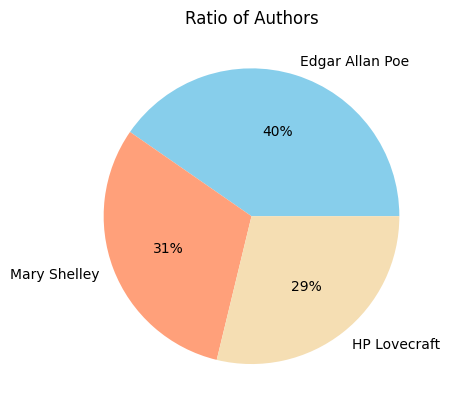

In [ ]:
# Check the ratio of the text from different authors (The target labels)
labels = train.author.replace(['EAP', 'MWS', 'HPL'], ['Edgar Allan Poe', 'Mary Shelley', 'HP Lovecraft']).value_counts().index
values = train.author.replace(['EAP', 'MWS', 'HPL'], ['Edgar Allan Poe', 'Mary Shelley', 'HP Lovecraft']).value_counts().values

plt.pie(values, labels = labels, colors = ['skyblue', 'lightsalmon', 'wheat'], autopct = '%1.0f%%')
plt.title('Ratio of Authors');

The dataset is roughly balanced, with about 10% more texts written by Edgar Allan Poe compared to the other two authors.  

The data type of the target variable 'author' is object, which may pose a challenge for calculating model performance later. I will create a new column, 'author_encoded', using the integers 0, 1, and 2 to represent the authors.

In [ ]:
# Create a new column of 'anthor_encoded'
author_mapping = {'EAP': 0, 'MWS': 1, 'HPL': 2}
train['author_encoded'] = train['author'].map(author_mapping)

In [ ]:
# Check if there is duplicated rows
print('There are ', train.duplicated(subset = ['text']).sum(), 'duplicated rows.')

There are  0 duplicated rows.


In [ ]:
# Take a look at the text from each author
pd.set_option('display.max_colwidth', 120)
for category, group in train.groupby('author'):
    print(category)
    print(group['text'].str.ljust(120).sample(5))
    print()

EAP
1883     Observing my partiality for domestic pets, she lost no opportunity of procuring those of the most agreeable kind.   ...
12131    I dreaded the first glance at objects around me.                                                                    ...
8065     The difficulty of breathing, however, was diminished in a very slight degree, and I found that it would soon be posi...
5595     During the whole of the day I continued to near the ice.                                                            ...
114      Yet all these appearances have been given I beg pardon will be given by the learned of future ages, to the Ashimah o...
Name: text, dtype: object

HPL
7292     And the cities of Cathuria are cinctured with golden walls, and their pavements also are of gold.                   ...
19073    Upon the death of Theodoric in , Ibidus retired from public life to compose his celebrated work whose pure Ciceronia...
13835    The evilly grinning beldame still clutched him, and b

In [ ]:
# Check if there are digits in the text
print('There are ', len(train[train['text'].str.contains(r'\d+')]), 'text contains digit.')

There are  0 text contains digit.


The text data appears clean, so I will skip the data cleaning.
  
  
### Feature Engineering  
    
I will explore the linguistic features which reflect the writing style of different authors through the following perspectives:    

1. **Flesch Reading Ease score**: a score that measures how easy a text is to read. The higher the score, the easier it is to understand the document.

2. **Gunning Fog Index**: a readability test for English writing. The index estimates the years of formal education a person needs to understand the text on the first reading.

3. **Sentence Length**: the average length of sentences in a text.

4. **Word Length**: the average length of words used by the authors.

5. **POS Tags Distribution**: frequencies of part-of-speech (POS) tags like nouns, verbs, adjectives, and adverbs.
  
6. **Usage of Function Words**: the ratio of function words to the total number of words.  
  
7. **Type-Token Ratio**: the ratio of unique words (types) to the total number of words (tokens) in a text.  
  
8. **Word Frequency**: the frequency of words used by the authors.  

In [ ]:
# Load spaCy's English model
nlp = spacy.load('en_core_web_sm')

# Define the function POS tags for function words
function_pos = {"DET", "PRON", "ADP", "CONJ", "AUX", "CCONJ", "SCONJ", "PART", "INTJ"}

# Define a function to extract features reflecting writing styles
def linguistic_features(text):
    # Flesch Reading Ease score
    flesch_reading_ease = textstat.flesch_reading_ease(text)

    # Gunning For Index
    gunning_fog_index = textstat.gunning_fog(text)

    # Creating a Doc container using spaCy package
    text = text.lower()
    doc = nlp(text)

    # Sentence length
    sentence_length = [len(sent) for sent in doc.sents]
    sentence_length_avg = np.mean(sentence_length) if sentence_length else 0

    # Word length
    word_length = [len(token.text) for token in doc if token.is_alpha]
    word_length_avg = np.mean(word_length) if word_length else 0

     # Count total words and unique words
    tokens = [token.text for token in doc if token.is_alpha]
    total_words = len(tokens)
    unique_words = len(set(tokens))

    # Count nouns, verbs, adj, adv, function words, and unique words
    count_nouns = len([token.text for token in doc if token.pos_ == 'NOUN'])
    count_verbs = len([token.text for token in doc if token.pos_ == 'VERB'])
    count_adj = len([token.text for token in doc if token.pos_ == 'ADJ'])
    count_adv = len([token.text for token in doc if token.pos_ == 'ADV'])
    count_function_words = len([token.text for token in doc if (token.is_alpha and token.pos_ in function_pos)])

    # Calculate ratios
    nouns_ratio =  count_nouns / total_words if total_words > 0 else 0
    verbs_ratio =  count_verbs / total_words if total_words > 0 else 0
    adj_ratio =  count_adj / total_words if total_words > 0 else 0
    adv_ratio =  count_adv / total_words if total_words > 0 else 0
    function_words_ratio = count_function_words / total_words if total_words > 0 else 0
    type_token_ratio = unique_words / total_words if total_words > 0 else 0

    return flesch_reading_ease, gunning_fog_index, sentence_length_avg, word_length_avg, nouns_ratio, verbs_ratio, adj_ratio, adv_ratio, function_words_ratio, type_token_ratio


In [ ]:
# Extract linguistic features of text data in training set
lingu_feature_train = train['text'].apply(linguistic_features).apply(pd.Series)
lingu_feature_train.columns = ['flesch_reading', 'gunning_fog', 'sent_len', 'word_len', 'noun_freq',
                               'verb_freq', 'adj_freq', 'adv_freq', 'funct_word', 'type_token']

train = pd.concat([train, lingu_feature_train], axis = 1)

In [ ]:
# Extract linguistic features of text data in test set
lingu_feature_test = test['text'].apply(linguistic_features).apply(pd.Series)
lingu_feature_test.columns = ['flesch_reading', 'gunning_fog', 'sent_len', 'word_len', 'noun_freq',
                               'verb_freq', 'adj_freq', 'adv_freq', 'funct_word', 'type_token']

test = pd.concat([test, lingu_feature_test], axis = 1)

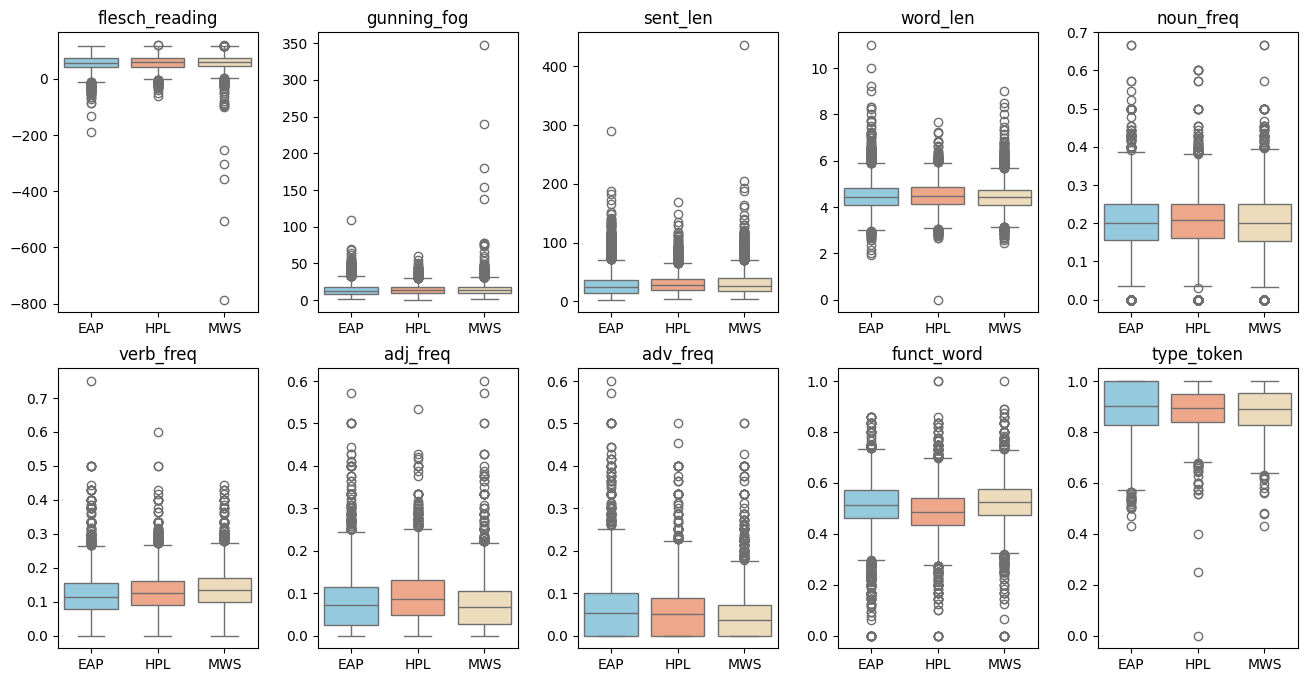

In [ ]:
# Create a figure with 10 subplots (2 rows and 5 columns)
fig, axs = plt.subplots(nrows = 2, ncols = 5, figsize = [16, 8])
plt.subplots_adjust(wspace = 0.3)

# Flatten the axs for easy iteration
axs = axs.flatten()

# The column names of linguistic features
lingu_cols = ['flesch_reading', 'gunning_fog', 'sent_len', 'word_len', 'noun_freq',
            'verb_freq', 'adj_freq', 'adv_freq', 'funct_word', 'type_token']

# Plot the linguistic features
for i, col in enumerate(lingu_cols):
    sns.boxplot(data = train, x = 'author', y = col, hue = 'author',
                palette = ['skyblue', 'lightsalmon', 'wheat'], ax = axs[i])
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    axs[i].set_title(col);

The plots above show slight deviations among authors in terms of linguistic features, but these differences are not very pronounced.

I will use an ANOVA test to determine if there are statistically significant differences between the means of these features across the author groups, setting $\alpha$ = 0.05.

In [ ]:
# Group the data by 'author'
authors = train['author'].unique()

# Apply ANOVA for each continuous feature across the author groups
for feature in lingu_cols:
    # Create groups for each author
    groups = [train[train['author'] == author][feature] for author in authors]

    # Perform one-way ANOVA
    f_statistic, p_value = f_oneway(*groups)

    # Print results
    print(f"Feature: {feature}, P-value: {p_value: .3f}")

Feature: flesch_reading, P-value:  0.067
Feature: gunning_fog, P-value:  0.000
Feature: sent_len, P-value:  0.000
Feature: word_len, P-value:  0.000
Feature: noun_freq, P-value:  0.002
Feature: verb_freq, P-value:  0.000
Feature: adj_freq, P-value:  0.000
Feature: adv_freq, P-value:  0.000
Feature: funct_word, P-value:  0.000
Feature: type_token, P-value:  0.002


Most of the p-values are less than 0.05, suggesting that there are statistically significant differences among the means of these features across the author groups, except for the Flesch Reading Score which has a p-value of 0.067. I will remove 'flesch_reading' from the training and test set, and keep the rest linguistic features.

However, the ANOVA test only tells us that there are differences between the groups, but it doesn't specify which groups differ or in what way. I will use Tukey HSD to uncover more details.

In [ ]:
# Drop the column 'flesch_reading'
train = train.drop(columns = ['flesch_reading'])
test = test.drop(columns = ['flesch_reading'])

In [ ]:
columns = ['gunning_fog', 'sent_len', 'word_len', 'noun_freq',
            'verb_freq', 'adj_freq', 'adv_freq', 'funct_word', 'type_token']

# Perform TukeyHSD
for col in columns:
    tukey = pairwise_tukeyhsd(endog = train[col], groups = train['author'], alpha = 0.05)
    print(col)
    print(tukey)
    print()

gunning_fog
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
   EAP    HPL    0.376 0.0199 0.0477 0.7043   True
   EAP    MWS   0.5817 0.0001   0.26 0.9034   True
   HPL    MWS   0.2057   0.35 -0.143 0.5543  False
--------------------------------------------------

sent_len
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   EAP    HPL   1.9877    0.0  1.2287 2.7467   True
   EAP    MWS   1.8321    0.0  1.0883  2.576   True
   HPL    MWS  -0.1556 0.8933 -0.9616 0.6505  False
---------------------------------------------------

word_len
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   EAP    HPL   0.0365 0.0009  0.0128  0.0602   True
   EAP    MWS  -0.0251 0.0305 -0.0

The Tukey HSD results show that:

* Texts by EAP are more difficult to read (higher Gunning Fog Index) and contain longer sentences than those by the other two authors.
* MWS tends to use longer words, followed by EAP, then HPL.
* EAP uses more nouns and verbs; MWS uses more nouns, adjectives, and adverbs; HPL uses more function words.
* MWS has the highest type-token ratio.
  
Now, let's check the authors' preference for particular vocabularies.    

In [ ]:
# Rename the column 'author' to avoid ambiguous ('author' could be both an index level and a column label in 'doc_term_df' below)
train.rename(columns = {'author': 'Author'}, inplace = True)

# Create a count vectorizer
cv = CountVectorizer(ngram_range = (1, 2), stop_words = 'english', min_df = 2)

# transform the text data in training set to a document-term matrix
doc_term_mx = cv.fit_transform(train['text'])

# Convert the document-term matrix to a DataFrame
doc_term_df = pd.DataFrame(doc_term_mx.toarray(), columns = cv.get_feature_names_out(),
                         index = train['Author'])

# Group by author and sum the value for each author
author_term = doc_term_df.groupby('Author').sum()
author_term = author_term.reset_index()


In [ ]:
# Define a function to plot top n-grams
def plot_top_ngrams(author, n_gram, top_n, ax):
    df = author_term[author_term['Author'] == author].drop(columns = 'Author').T
    df.columns = ['Frequency']
    ngrams = [ngram for ngram in df.index if len(ngram.split()) == n_gram]
    df_ngrams = df.loc[ngrams, 'Frequency'].sort_values(ascending = False).head(top_n).to_frame()

    sns.barplot(x = df_ngrams['Frequency'], y = df_ngrams.index, color = 'skyblue', ax = ax)
    ax.set_title(f'Top {top_n} {n_gram}-grams from {author}')
    ax.set_ylabel('')

    return ax


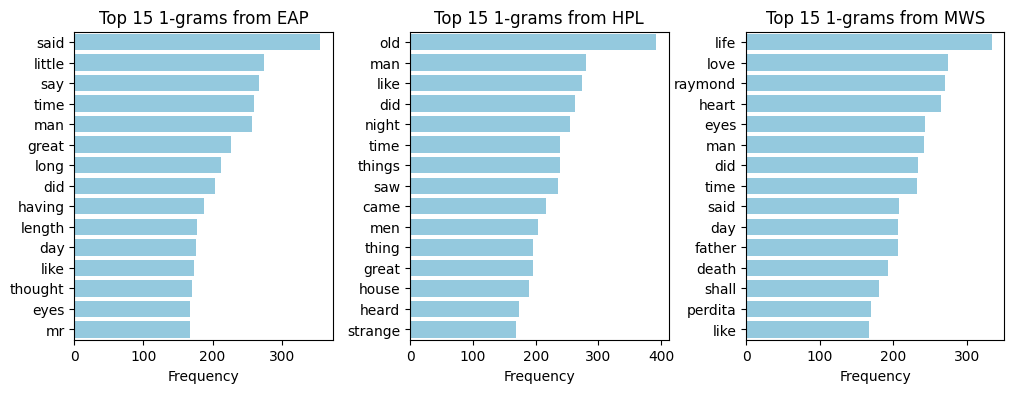

In [ ]:
# Plot top unigrams
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4))
plt.subplots_adjust(wspace = 0.3)

for i, author in enumerate(train['Author'].unique()):
    plot_top_ngrams(author, 1, 15, ax[i])

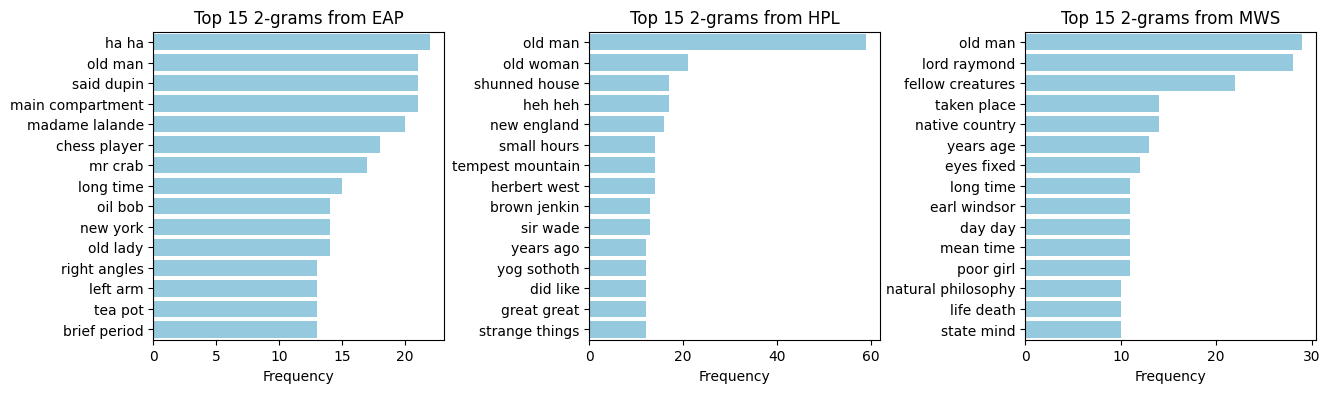

In [ ]:
# Plot top bigrams
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 4))
plt.subplots_adjust(wspace = 0.5)

for i, author in enumerate(train['Author'].unique()):
    plot_top_ngrams(author, 2, 15, ax[i])

As we can see from the plots above, there are multiple overlapping top unigrams and even bigrams across the authors. For example: 'old man', 'years ago', and 'long time'. This makes sense, since they all come from the same genre—horror stories.

##### Summary of EDA  

Here is what I have done during the EDA:

* Checked the proportion of each target label (author) in the training set and found that the dataset is roughly **balanced**.

* Created a new column, 'author_encoded', using integers to represent the authors (**label encoding**) in order to address the challenge of model performance calculation.  
  
* Reviewed the text data and found it **clean**, so skipped data cleaning.  

* Explored **linguistic features** which reflect authors' writing styles through features such as Gunning Fog Index, sentence length, word length, POS Tags Distribution, function word usage, type-token ratio. The results of ANOVA test and TukeyHSD shows that there are statistically significant differences among the means of most linguistic features across the author groups, except for the Flesch Reading Score.

* Plotted the **top n-grams** by author and observed several overlapping top unigrams and bigrams across the authors, making the distinction between them relatively small in terms of word frequency.  
  
**Potential Challenges**:   
  
The overlap of top n-grams blurs the boundaries between the authors, potentially challenging the performance of models we plan to build

In [ ]:
train.to_csv('/content/drive/MyDrive/ColabNotebooks/Spooky_Author_Identification/train.csv', index = False)
test.to_csv('/content/drive/MyDrive/ColabNotebooks/Spooky_Author_Identification/test.csv', index = False)

### Modeling  

**Models**


* BiLSTM with regularization
* BERT Model


**Metrics**
This is a multi-class classification problem. I will use accuracy as the primary evaluation metric, while log-loss will be used for submissions, as the Kaggle competition evaluates models using multi-class logarithmic loss. Efficiency (wall time) will also be considered if the accuracies of two models are very close.


In [4]:
# Split the training set to training and validation set
training_set, validation_set = train_test_split(train, test_size = 0.2, stratify = train['Author'], random_state = 1)

In [21]:
# Check the number of unique words in the text data
words = re.sub(r'[^\w\s]', '', ' '.join(training_set['text']).lower()).split()
vocab_size = len(set(words))
vocab_size

23230

In [22]:
# Check the length of each text
text_length = training_set['text'].str.split().str.len()
print(text_length.describe())

# Find the 95th percentile
sequence_length = int(text_length.quantile(0.95))
print(f'95% of texts have {sequence_length} words or fewer.')


count    15663.000000
mean        26.726553
std         19.472995
min          2.000000
25%         15.000000
50%         23.000000
75%         34.000000
max        861.000000
Name: text, dtype: float64
95% of texts have 58 words or fewer.


The length of the text data has a wide range, from 2 to 861, with a mean of 27 and a median of 23. Since 95% of texts have 58 words or fewer, I will set the sequence length in the TextVectorization to be 58.

In [23]:
# Create the text vectorizer
vectorizer = TextVectorization(
    max_tokens = vocab_size,
    output_mode = 'int',
    output_sequence_length = sequence_length
)

# Build a vocabulary of all string tokens seen in the training_set['text']
vectorizer.adapt(training_set['text'].values)

# Vectorize the data
training_text = vectorizer(training_set['text'].values)
validation_text = vectorizer(validation_set['text'].values)

#### The first Bidirectional LSTM model

In [ ]:
# An integer input for vocabulary indices
inputs = Input(shape = (None, ), dtype = 'int64')

# Embedding layer
x = Embedding(vocab_size + 1, 128)(inputs)

# Embedding dropout
x = SpatialDropout1D(0.1)(x)

# Bidirectional LSTM layer
x = Bidirectional(LSTM(512, recurrent_dropout = 0.2, return_sequences=True))(x)

# Maxpooling layer
x = GlobalMaxPooling1D()(x)

# Dropout
x = Dropout(0.5)(x)

# Output
outputs = Dense(3, activation = 'softmax')(x)

bi_lstm1 = Model(inputs, outputs)
bi_lstm1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, None, 128)           │       2,973,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, None, 1024)          │       2,625,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 1024)                │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,602,179 (21.37 MB)

 Trainable params: 5,602,179 (21.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model with optimizer, loss function, and metrics
bi_lstm1.compile(optimizer = Adam(learning_rate = 0.001),
    loss = SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

I'll define a custom callback called `TemporalAveraging` that performs temporal averaging of model weights at the epoch level. It maintains an exponential moving average (EMA) during training and loads the averaged weights into the model at the end.

In [8]:
@register_keras_serializable()
class TemporalAveraging(Callback):
    def __init__(self, beta=0.99):
        super().__init__()
        self.beta = beta
        self.ema_weights = None
        self.epochs = 0

    # Initialize EMA weights at the start of training
    def on_train_begin(self, logs=None):
        self.ema_weights = [w.numpy() for w in self.model.trainable_weights]
        self.epochs = 0

    # Update EMA weights after each epoch
    def on_epoch_end(self, epoch, logs=None):
        self.epochs += 1
        for i, w in enumerate(self.model.trainable_weights):
            current_w = w.numpy()
            self.ema_weights[i] = (
                self.beta * self.ema_weights[i] + (1.0 - self.beta) * current_w
            )

    # Load the averaged weights into the model at the end of training
    def on_train_end(self, logs=None):
        # Correction to counteract bias towards zero at the start
        correction = 1.0 - self.beta ** self.epochs if self.epochs > 0 else 1.0
        corrected_weights = [w / correction for w in self.ema_weights]

        # Update model weights with averaged weights
        for w, avg_w in zip(self.model.trainable_weights, corrected_weights):
            w.assign(avg_w)

    # Returns the config of the callback. Enables serialization and deserialization
    def get_config(self):
        config = super().get_config()
        config.update({
            'beta': self.beta,
        })
        return config

In [9]:
# Define the other callbacks
early_stoppig = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 5,
    verbose = 1,
    restore_best_weights = True
)

check_point = ModelCheckpoint(
    filepath = '/content/drive/MyDrive/ColabNotebooks/Spooky_Author_Identification/trained_embedding_lstm1.keras',
    monitor = 'val_accuracy',
    save_best_only = True
)

reduced_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.5,
    patience = 3,
    verbose = 1
)

In [ ]:
history1 = bi_lstm1.fit(
    training_text,
    training_set['author_encoded'],
    steps_per_epoch = math.ceil(training_set.shape[0] / 64),
    batch_size = 64,
    validation_data = (validation_text, validation_set['author_encoded']),
    validation_steps = math.ceil(validation_set.shape[0] / 64),
    epochs = 20,
    callbacks = [early_stoppig, check_point, reduced_lr, TemporalAveraging()]
)

Epoch 1/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 109s 425ms/step - accuracy: 0.5101 - loss: 0.9772 - val_accuracy: 0.8085 - val_loss: 0.5106 - learning_rate: 0.0010
Epoch 2/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 136s 410ms/step - accuracy: 0.8809 - loss: 0.3353 - val_accuracy: 0.8322 - val_loss: 0.4305 - learning_rate: 0.0010
Epoch 3/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 106s 435ms/step - accuracy: 0.9472 - loss: 0.1541 - val_accuracy: 0.8368 - val_loss: 0.4759 - learning_rate: 0.0010
Epoch 4/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 118s 337ms/step - accuracy: 0.9694 - loss: 0.0864 - val_accuracy: 0.8266 - val_loss: 0.5998 - learning_rate: 0.0010
Epoch 5/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.9839 - loss: 0.0502
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
245/245 ━━━━━━━━━━━━━━━━━━━━ 143s 341ms/step - accuracy: 0.9839 - loss: 0.0503 - val_accuracy: 0.8159 - val_loss: 0.6624 - learning_rate: 0.0010
Epoch 6/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 146s 357ms/step - accuracy:

Early stopping was triggered at epoch 8, with the best weights occurring at epoch 3 (val_accuracy 0.8368). The training accuracy gets to 0.99 in the end, while the validation accuracy hovered around 0.8, indicating overfitting.  


#### Bidirectional LSTM with linguistic features

I will add linguistic features to the model and also include a ReduceLROnPlateau callback, which will reduce the learning rate by 50% when the validation loss stays on a plateau for 3 epochs.

In [ ]:
# Extract linguistic features
lingu_train = training_set[['gunning_fog', 'sent_len', 'word_len', 'noun_freq',
            'verb_freq', 'adj_freq', 'adv_freq', 'funct_word', 'type_token']]
lingu_validation = validation_set[['gunning_fog', 'sent_len', 'word_len', 'noun_freq',
            'verb_freq', 'adj_freq', 'adv_freq', 'funct_word', 'type_token']]

# Normalize the linguistic features
scaler = StandardScaler()
lingu_train = scaler.fit_transform(lingu_train)
lingu_validation = scaler.transform(lingu_validation)

In [ ]:
# Define the input layer for text
input_text = Input(shape = (None, ), dtype = 'int64')

# Define the input layer for linguistic features
input_lingu = Input(shape = (9, ))

# Embedding layer
x = Embedding(vocab_size + 1, 128)(input_text)

# Embedding dropout
x = SpatialDropout1D(0.1)(x)

# Bidirectional LSTM layer
x = Bidirectional(LSTM(512, recurrent_dropout = 0.2, return_sequences=True))(x)

# Maxpooling layer
x = GlobalMaxPooling1D()(x)

# Concatenate maxpooling layer and the linguistic features
x = Concatenate()([x, input_lingu])

# Dropout
x = Dropout(0.5)(x)

# Output
outputs = Dense(3, activation = 'softmax')(x)

bi_lstm2 = Model([input_text, input_lingu], outputs)
bi_lstm2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 128)      │      2,973,568 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout1d_1       │ (None, None, 128)      │              0 │ embedding_1[0][0]      │
│ (SpatialDropout1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, None, 1024)     │      2,625,536 │ spatial_dropout1d_1[0… │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_1    │ (None, 1024)           │              0 │ bidirectional_1[0][0]  │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 9)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 1033)           │              0 │ global_max_pooling1d_… │
│                           │                        │                │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 1033)           │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 3)              │          3,102 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,602,206 (21.37 MB)

 Trainable params: 5,602,206 (21.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model with optimizer, loss function, and metrics
bi_lstm2.compile(optimizer = Adam(learning_rate = 0.001),
    loss = SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

# Define new callbacks
check_point2 = ModelCheckpoint(
    filepath = '/content/drive/MyDrive/ColabNotebooks/Spooky_Author_Identification/trained_embedding_lstm2.keras',
    monitor = 'val_accuracy',
    save_best_only = True
)

history2 = bi_lstm2.fit(
    [training_text, lingu_train],
    training_set['author_encoded'],
    steps_per_epoch = math.ceil(training_set.shape[0] / 64),
    batch_size = 64,
    validation_data = ([validation_text, lingu_validation], validation_set['author_encoded']),
    validation_steps = math.ceil(validation_set.shape[0] / 64),
    epochs = 20,
    callbacks = [early_stoppig, check_point2, reduced_lr, TemporalAveraging()]
)

Epoch 1/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 89s 341ms/step - accuracy: 0.4922 - loss: 0.9860 - val_accuracy: 0.8039 - val_loss: 0.4953 - learning_rate: 0.0010
Epoch 2/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 82s 336ms/step - accuracy: 0.8590 - loss: 0.3786 - val_accuracy: 0.8218 - val_loss: 0.4524 - learning_rate: 0.0010
Epoch 3/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 142s 338ms/step - accuracy: 0.9423 - loss: 0.1746 - val_accuracy: 0.8330 - val_loss: 0.4978 - learning_rate: 0.0010
Epoch 4/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 141s 336ms/step - accuracy: 0.9671 - loss: 0.0919 - val_accuracy: 0.8174 - val_loss: 0.6577 - learning_rate: 0.0010
Epoch 5/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.9797 - loss: 0.0605
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
245/245 ━━━━━━━━━━━━━━━━━━━━ 81s 331ms/step - accuracy: 0.9797 - loss: 0.0605 - val_accuracy: 0.8230 - val_loss: 0.6241 - learning_rate: 0.0010
Epoch 6/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 81s 329ms/step - accuracy: 0.9

Early stopping was triggered at epoch 8, with the best weights occurring at epoch 3 (val_accuracy 0.833). The overfitting problem is still existing and the model performance didn't improve after adding linguistic features into the model. I will proceed with tunning the first Bi_LSTM model.

### Tune the model

I will tune the hyperparameters of the first model using `BayesianOptimization` from keras_tunner as follows:

* Embedding output dimension
* Embedding dropout rate
* Number of units in LSTM layer
* Recurrent dropout rate in LSTM layer
* Max-pooled output dropout rate
* Learning rate

In [15]:
def build_model(hp):
    input_text = Input(shape = (None, ), dtype = 'int64')

    x = Embedding(vocab_size + 1,
                  output_dim = hp.Choice('embedding_dim',
                                         values = [64, 128, 256])
                  )(input_text)
    x = SpatialDropout1D(rate = hp.Choice('embedding_dropout',
                                          values = [0.1, 0.2, 0.3]))(x)
    x = Bidirectional(LSTM(units = hp.Choice('lstm_units',
                                             values = [64, 128, 256, 512]),
                           recurrent_dropout = hp.Choice('recurrent_dropout',
                                                         values = [0.2, 0.3, 0.4]),
                           return_sequences=True))(x)
    x = GlobalMaxPooling1D()(x)

    x = Dropout(rate = hp.Choice('max_pool_dropout',
                                 values = [0.3, 0.4, 0.5]))(x)
    outputs = Dense(3, activation = 'softmax')(x)
    model = Model(input_text, outputs)
    model.compile(optimizer = Adam(learning_rate = hp.Choice('learning_rate',
                                                             values = [0.001, 0.0001])),
                  loss = SparseCategoricalCrossentropy(),
                  metrics = ['accuracy'])
    return model

In [ ]:
# Create the tuner
tuner = BayesianOptimization(
    build_model,
    objective = 'val_accuracy',
    max_trials = 20
)

# Search for the best hyperparameters
tuner.search(
    training_text,
    training_set['author_encoded'],
    steps_per_epoch = math.ceil(training_set.shape[0] / 64),
    batch_size = 64,
    validation_data = (validation_text, validation_set['author_encoded']),
    validation_steps = math.ceil(validation_set.shape[0] / 64),
    epochs = 20,
    callbacks = [early_stoppig, reduced_lr, TemporalAveraging()]
)

Trial 17 Complete [00h 39m 46s]
val_accuracy: 0.8232890963554382

Best val_accuracy So Far: 0.8424412608146667
Total elapsed time: 07h 47m 58s

Search: Running Trial #18

Value             |Best Value So Far |Hyperparameter
64                |256               |embedding_dim
0.2               |0.3               |embedding_dropout
512               |128               |lstm_units
0.3               |0.2               |recurrent_dropout
0.5               |0.5               |max_pool_dropout
0.001             |0.001             |learning_rate

Epoch 1/20
 66/245 ━━━━━━━━━━━━━━━━━━━━ 1:00 339ms/step - accuracy: 0.4043 - loss: 1.0880

The runtime of Google Colab was disconnected when the tuner was running the 18th trial. Throughout the search, two sets of "Best Value So Far" appeared, and each remained best for multiple trials. I will use these two hyperparameter sets to retrain a model and adopt the one that performs better.

In [14]:
# An integer input for vocabulary indices
inputs = Input(shape = (None, ), dtype = 'int64')

# Embedding layer
x = Embedding(vocab_size + 1, 256)(inputs)

# Embedding dropout
x = SpatialDropout1D(0.3)(x)

# Bidirectional LSTM layer
x = Bidirectional(LSTM(128, recurrent_dropout = 0.2, return_sequences=True))(x)

# Maxpooling layer
x = GlobalMaxPooling1D()(x)

# Dropout
x = Dropout(0.5)(x)

# Output
outputs = Dense(3, activation = 'softmax')(x)

tuned_lstm = Model(inputs, outputs)
tuned_lstm.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, None, 256)           │       5,947,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_2                  │ (None, None, 256)           │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, None, 256)           │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_2               │ (None, 256)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,342,147 (24.19 MB)

 Trainable params: 6,342,147 (24.19 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Compile the model with optimizer, loss function, and metrics
tuned_lstm.compile(optimizer = Adam(learning_rate = 0.001),
    loss = SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

# Define new callbacks
check_point_tuned = ModelCheckpoint(
    filepath = '/content/drive/MyDrive/ColabNotebooks/Spooky_Author_Identification/tuned_lstm.keras',
    monitor = 'val_accuracy',
    save_best_only = True
)

history_tuned = tuned_lstm.fit(
    training_text,
    training_set['author_encoded'],
    steps_per_epoch = math.ceil(training_set.shape[0] / 64),
    batch_size = 64,
    validation_data = (validation_text, validation_set['author_encoded']),
    validation_steps = math.ceil(validation_set.shape[0] / 64),
    epochs = 20,
    callbacks = [early_stoppig, check_point_tuned, reduced_lr, TemporalAveraging()]
)

Epoch 1/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 87s 334ms/step - accuracy: 0.5177 - loss: 0.9519 - val_accuracy: 0.8205 - val_loss: 0.4615 - learning_rate: 0.0010
Epoch 2/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 80s 327ms/step - accuracy: 0.8784 - loss: 0.3225 - val_accuracy: 0.8325 - val_loss: 0.4491 - learning_rate: 0.0010
Epoch 3/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 83s 332ms/step - accuracy: 0.9478 - loss: 0.1517 - val_accuracy: 0.8340 - val_loss: 0.4778 - learning_rate: 0.0010
Epoch 4/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 80s 323ms/step - accuracy: 0.9706 - loss: 0.0886 - val_accuracy: 0.8269 - val_loss: 0.5990 - learning_rate: 0.0010
Epoch 5/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.9810 - loss: 0.0563
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
245/245 ━━━━━━━━━━━━━━━━━━━━ 82s 324ms/step - accuracy: 0.9810 - loss: 0.0563 - val_accuracy: 0.8269 - val_loss: 0.6463 - learning_rate: 0.0010
Epoch 6/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 82s 323ms/step - accuracy: 0.988

In [16]:
# An integer input for vocabulary indices
inputs = Input(shape = (None, ), dtype = 'int64')

# Embedding layer
x = Embedding(vocab_size + 1, 128)(inputs)

# Embedding dropout
x = SpatialDropout1D(0.3)(x)

# Bidirectional LSTM layer
x = Bidirectional(LSTM(128, recurrent_dropout = 0.2, return_sequences=True))(x)

# Maxpooling layer
x = GlobalMaxPooling1D()(x)

# Dropout
x = Dropout(0.5)(x)

# Output
outputs = Dense(3, activation = 'softmax')(x)

tuned_lstm2 = Model(inputs, outputs)
tuned_lstm2.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_3 (Embedding)              │ (None, None, 128)           │       2,973,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_3                  │ (None, None, 128)           │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, None, 256)           │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_3               │ (None, 256)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,237,507 (12.35 MB)

 Trainable params: 3,237,507 (12.35 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Compile the model with optimizer, loss function, and metrics
tuned_lstm2.compile(optimizer = Adam(learning_rate = 0.001),
    loss = SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

# Define new callbacks
check_point_tuned2 = ModelCheckpoint(
    filepath = '/content/drive/MyDrive/ColabNotebooks/Spooky_Author_Identification/tuned_lstm2.keras',
    monitor = 'val_accuracy',
    save_best_only = True
)

history_tuned2 = tuned_lstm2.fit(
    training_text,
    training_set['author_encoded'],
    steps_per_epoch = math.ceil(training_set.shape[0] / 64),
    batch_size = 64,
    validation_data = (validation_text, validation_set['author_encoded']),
    validation_steps = math.ceil(validation_set.shape[0] / 64),
    epochs = 20,
    callbacks = [early_stoppig, check_point_tuned2, reduced_lr, TemporalAveraging()]
)

Epoch 1/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 82s 317ms/step - accuracy: 0.4916 - loss: 0.9963 - val_accuracy: 0.8041 - val_loss: 0.4810 - learning_rate: 0.0010
Epoch 2/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 85s 330ms/step - accuracy: 0.8661 - loss: 0.3616 - val_accuracy: 0.8424 - val_loss: 0.3994 - learning_rate: 0.0010
Epoch 3/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 79s 322ms/step - accuracy: 0.9357 - loss: 0.1790 - val_accuracy: 0.8287 - val_loss: 0.4856 - learning_rate: 0.0010
Epoch 4/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 81s 318ms/step - accuracy: 0.9605 - loss: 0.1133 - val_accuracy: 0.8348 - val_loss: 0.5129 - learning_rate: 0.0010
Epoch 5/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.9756 - loss: 0.0712
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
245/245 ━━━━━━━━━━━━━━━━━━━━ 83s 324ms/step - accuracy: 0.9756 - loss: 0.0712 - val_accuracy: 0.8281 - val_loss: 0.5546 - learning_rate: 0.0010
Epoch 6/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 81s 320ms/step - accuracy: 0.985

The second model performs slightly better than the first one. I will print the classification report of the model's performance on the validation set.

In [ ]:
# Load the weights
tuned_lstm2.load_weights('/content/drive/MyDrive/ColabNotebooks/Spooky_Author_Identification/tuned_lstm2.keras')

In [43]:
# Print the classification report of the model's performance on the validation set
pred_prob = tuned_lstm2.predict(validation_text, verbose = 0)
y_pred = np.argmax(pred_prob, axis = 1)
print(classification_report(validation_set['author_encoded'], y_pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      1580
           1       0.83      0.84      0.83      1209
           2       0.91      0.80      0.85      1127

    accuracy                           0.84      3916
   macro avg       0.85      0.84      0.84      3916
weighted avg       0.85      0.84      0.84      3916



In [40]:
# Prepare the test data
test_text = vectorizer(test['text'].values)

# Make prediction on the test set
prediction = tuned_lstm2.predict(test_text, verbose=0)

# Create the submission dataframe
lstm_prediction = pd.DataFrame(prediction, columns = ['EAP', 'MWS', 'HPL'])
lstm_prediction = pd.concat([test['id'], lstm_prediction], axis = 1)
lstm_prediction = lstm_prediction[['id', 'EAP', 'HPL', 'MWS']]

In [41]:
lstm_prediction.head()

,id,EAP,HPL,MWS
0,id02310,0.052381,0.011485,0.936134
1,id24541,0.985097,0.011552,0.003351
2,id00134,0.077188,0.908230,0.014582
3,id27757,0.981029,0.014740,0.004231
4,id04081,0.805896,0.087549,0.106555


In [42]:
lstm_prediction.to_csv('/content/drive/MyDrive/ColabNotebooks/Spooky_Author_Identification/lstm_prediction.csv', index = False)

After submit to Kaggle I got a private score of 0.41 and public score of 0.42 (log-loss).